# ToDo 

_data cleaning_
* crt (in seconds: < 2seconds-normal >2seconds:unhealthy)
* mmcolour (healthy/not healthy)
* temperature
* ...

# Data cleaning

## Prep 

### Imports

In [59]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
import numpy as np

#import plotly.graph_objects as go
#from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode()
#import plotly.express as px

import re
import matplotlib.pyplot as plt

### Reading data 

In [3]:
columns = ['DatabaseName', 'PatientNumber', 'ClientNumber', 'ConsultationNumber', 'ItemName', 'Units',
           'ItemLabel', 'ClinicCode', 'ConsultingVet', 'PatientDesexed', 'DeceasedDate',
           'VisitDate', 'ConsultationDate', 'ExaminationText' ,'PatientSpecies', 'PatientBreed',
           'PatientColour', 'PatientSex', 'PatientDoB', 'Insured', 'weight', 'temperature',
           'HeartRate', 'BodyScore', 'DentalGrade', 'RespRate', 'PainScore', 'BP', 'CRT', 'MMColour']

In [4]:
data_dir = "../Data/vet_compass/"
data = pd.read_csv(data_dir + 'STR024A03 20190719 sample x10,000.csv', header=None, names = columns)

/Users/ruth/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,2,3,19,20,21,22,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data['VisitDate']= pd.to_datetime(data['VisitDate']).dt.date
data['ConsultationDate']= pd.to_datetime(data['ConsultationDate']).dt.date
data['DeceasedDate']= pd.to_datetime(data['DeceasedDate']).dt.date
data['PatientDoB']= pd.to_datetime(data['PatientDoB']).dt.date
data['PatientNumber'] = data['PatientNumber'].astype("str")
data['weight'] = data['weight'].astype("str")

## Data cleaning 

### Weight 

In [6]:
def clean_weights(df, grams_threshold=20):
    """
    Clean weight column of VetCompass data inplace

    Keyword arguments:
    df -- pandas.DataFrame to clean, must contain a 'weight' column
    grams_threshold -- threshold at which to assume an entered value is in grams
    
    Returns:
    df -- modified pandas.DataFrame containing 'weight_kg' column. 'weight' column is dropped.
    """
    
    # Make a copy of the weight column to clean
    df['weight_kg'] = df['weight']
    
    # Remove weights that are in cage or carrier
    df.loc[df['weight_kg'].str.contains('cage|carrier', na=False), 'weight_kg'] = np.nan
    
    # make kg column with values extracted
    # patterns: digits.,digits OR .,digits
    df['weight_kg'] = df['weight_kg'].astype(str).str.extract(r'(\d+[\.,]*\d*|[\.,]\d+)')
    
    # clean mistaken decimal points
    df['weight_kg'] = df['weight_kg'].str.replace('\.\.|,\.|\.,|,', '.')
    
    # coerce to numeric
    df['weight_kg'] = pd.to_numeric(df['weight_kg'], errors="coerce")
    
    # find entries with values greater than 20 (likely in grams rather than kg)
    df.loc[df['weight_kg']>grams_threshold, 'weight_kg'] = df['weight_kg']/1000.0
    
    # drop original weights column
    df = df.drop('weight', axis=1)
    
    return df

In [7]:
data = clean_weights(data)

### Breeds 

In [ ]:
# from the paper:  Asian (green), Western European (red), East African (purple), Mediterranean basin (blue)
#and wildcat (black) populations form strongly supported monophyletic branches.

In [14]:
def makeBreedDict():
    breedGroup = dict()
    colourGroup = dict(WesternEuropean = ['Sphynx', 'New York', 'Maine Coon', 'Norwegian Forest', 'Siberian', 'Abyssinian', 'British', 'Persian', 'Exotic', 'Russian Blue'],
    MediterraneanBasin = ['Turkish Van', 'Turkish Angora', 'Egyptian Mau'],
    Asian = ['Korat', 'Burmese', 'Singapura', 'Siamese', 'Birman'],
    EastAfrican = ['Sokoke'])

    for c in list(colourGroup.keys()):
        for b in colourGroup[c]:
            breedGroup[b] = c
    
    return breedGroup

def getBreedColour(x, breedGroup):
    try:
        c = breedGroup[x]
        return c
    except:    
        return x

def unifyBreed(breedSeries):
    returnSeries = pd.Series
    returnSeries.name = 'UnifiedBreed'
    returnSeries = breedSeries
    returnSeries = returnSeries.str.replace(r',', '')
    returnSeries = returnSeries.str.replace(r'\ X', '')
    returnSeries = returnSeries.str.replace(r'\ Haired', '')
    returnSeries = returnSeries.str.replace(r'\ Hair', '')
    returnSeries = returnSeries.str.replace(r'hair', '')
    returnSeries = returnSeries.str.replace(r'\ Semi', '')
    returnSeries = returnSeries.str.replace(r'\ Short', '')
    returnSeries = returnSeries.str.replace(r'\ Shorthair', '')
    returnSeries = returnSeries.str.replace(r'\ Medium', '')
    returnSeries = returnSeries.str.replace(r'\ Long', '')
    returnSeries = returnSeries.str.replace(r'Unknown', 'Other')
    
    breedGroup = makeBreedDict()

    returnSeries = returnSeries.apply(lambda x: getBreedColour(x, breedGroup))
    
    return returnSeries

In [15]:
data['UnifiedBreed'] = unifyBreed(data.PatientBreed)

add columns for weight quartiles for breed

In [21]:
groupWeight = data.groupby('PatientBreed').describe()["weight_kg"]

data['weight_25%'] = data.PatientBreed.apply(lambda breed: groupWeight['25%'][["PatientBreed"] == breed])
data['weight_50%'] = data.PatientBreed.apply(lambda breed: groupWeight['50%'][["PatientBreed"] == breed])
data['weight_75%'] = data.PatientBreed.apply(lambda breed: groupWeight['75%'][["PatientBreed"] == breed])

### BodyScore 

In [22]:
def convertSimpleCases(x):
    x = str(x).lower()

#   all those special cases
    x = re.sub(r'\/{2,}', '/', x)
    x = re.sub(r'\ ', '', x)
    x = re.sub(r'\.\.', '.', x)
    x = re.sub(r'\,', '/', x)
    x = re.sub(r'\;', '', x)
  
    x = re.sub(r'overweight','7/9', x)
    x = re.sub(r'normal','5/9', x)
    x = re.sub(r'fair','7/9', x)
    x = re.sub(r'q4','4/5', x)
    x = re.sub(r'goodhaslostsomeweight','7/9', x)
    x = re.sub(r'>3','3', x)
    x = re.sub(r'poor','1/5', x)
    x = re.sub(r'lean','2/5', x)
    x = re.sub(r'good','5/9', x)
    
    x = re.sub(r'506/9','5-6/9', x)
    x = re.sub(r'55/9','5/9', x)
    x = re.sub(r'44/9','4/9', x)
    x = re.sub(r'78/9', '7-8/9', x)
    
    x = re.sub(r'%', '', x)
    x = re.sub(r'nan', '', x)
    
    x = re.sub(r'3\.5\.5', '3.5', x)
    
               
#     find something - something
    p = re.compile('\d(\.\d+)?\-\d(\.\d+)?')
    m = p.match(x)
    if m:
        y = np.average([float(m.group().split('-')[0]),float(m.group().split('-')[1])])
        x = re.sub(r'\d(\.\d+)?\-\d(\.\d+)?', str(y), x)

    x = re.sub(r'\+', '', x)
    x = re.sub(r'\-', '', x)
    
    x = re.sub(r'\.\/','/', x)
     
    
#     something(.something?)/somethingElse
    p = re.compile('\d(\.\d+)?\/\d')
    m = p.match(x)
    if m:
        firstPart = float(m.group().split('/')[0])
        secondPart = float(m.group().split('/')[1])
        if secondPart == 0:
            secondPart = 9
        return firstPart/secondPart

    else: 
        return x

In [23]:
# 2 scoring systems: out of 5 or out of 9.  
#Use the quartiles to figure out which scoring system is more likely to have been used
def convertTrickyCases(x, weight, lowerQuartile, median, upperQuartile):
    if isinstance(x, str) or isinstance(x, float):
        try: 
            x = float(x)
            if x > 9:
                return np.nan
            elif x > 5:
                return float(x/9)
            elif x >= 4:
                if weight > upperQuartile:
                    return float(x/5)
                else:
                    return float(x/9)
            elif x >= 3:
                if weight < lowerQuartile:
                    return float(x/9)
                else:
                    return float(x/5)
            elif x >= 1:
                return float(x/7)
            else:
                return x
        except:
            return x
    else:
        return x

In [24]:
def convertBodyScoreRows(x):
#     print(x.BodyScore)
    newBodyScore = convertSimpleCases(x.BodyScore)
    newBodyScore = convertTrickyCases(newBodyScore, x.weight_kg, x['weight_25%'], x['weight_50%'], x['weight_75%'])
    return newBodyScore

In [25]:
data["UnifiedBodyScore"] = data[['BodyScore', 'weight_kg', 'weight_25%', 'weight_50%', 'weight_75%']].apply(convertBodyScoreRows, axis=1) 

### Age

In [26]:
data["age"] = data["ConsultationDate"] - data["PatientDoB"]

In [27]:
data["age"] = data["age"].apply(lambda x: x.days)

In [28]:
len(data[data.age < 0])

6842

### Dental score

In [29]:
def clean_dentalgrade(df):
    """
    Clean DentalGrade column of VetCompass data inplace

    Keyword arguments:
    df -- pandas.DataFrame to clean, must contain a 'DentalGrade' column

    Returns:
    df -- modified pandas.DataFrame containing 'DentalGrade_num' column. 'DentalGrade' column is dropped.
    """
    
    # Make a copy of the DentalGrade column to clean. Lower strings before starting
    df['DentalGrade_str'] = df['DentalGrade'].str.lower()
    df['DentalGrade_num'] = pd.to_numeric(df['DentalGrade'], errors="coerce")
    
    # Set any values correpsonding to baby teeth as 0 - healthy value
    df.loc[df["DentalGrade_str"].str.contains('dec|baby|teething|kitten|juv', na=False), "DentalGrade_num"] = 0.0
    
    # Clean any entries fromatted as c{}/g{} or g{}/c{}, assuming that scores are given out of 4 in this instance
    # Take mean of both c (teeth) and g (gum) scores before calculating relative value out of 4
    loc_contains_cg = df["DentalGrade_str"].str.contains('g[0-9]/|c[0-9]/', na=False, regex=True)
    
    df[['cgsplit_right','cgsplit_left']] = df.loc[loc_contains_cg, "DentalGrade_str"].str.split(pat="/", expand=True)
    
    df['cgsplit_right'] = pd.to_numeric(df['cgsplit_right'].str[-1])
    df['cgsplit_left'] = pd.to_numeric(df['cgsplit_left'].str[-1])
    
    df.loc[loc_contains_cg, "DentalGrade_num"] = df[['cgsplit_right', 'cgsplit_left']].mean(axis=1)/4.0
    
    df = df.drop(['cgsplit_right', 'cgsplit_left'], axis=1)
    
    # Clean any entries formated as {}/{}, removing entries that are out of 6 or 9
    loc_contains_ratio = df["DentalGrade_str"].str.contains('[0-9]/[0-9]', na=False, regex=True)
    
    df.loc[df["DentalGrade_str"].str.contains('/6', na=False)] = np.nan
    df.loc[df["DentalGrade_str"].str.contains('/9', na=False)] = np.nan
    
    df[['ratio_right', 'ratio_left', 'ratio_extra']] = df.loc[loc_contains_ratio, 'DentalGrade_str'].str.split(pat='/', expand=True)
    
    ratio_replace_dict = {'1-2': '1.5',
                          '2-3': '2.5',
                          '0-1': '0.5',
                          '<1': '0.5',
                          '-12': '1.5',
                          '1-4': '2',
                          '3-4': '3.5',
                          ' 0': '0',
                          'late 2': '2', 
                          '1-3': '2',
                          '>1': '1.5'}
   
    df['ratio_right'] = pd.to_numeric(df['ratio_right'].replace(ratio_replace_dict, regex=False))
    df['ratio_left'] = pd.to_numeric(df['ratio_left'].str[0])
    df.loc[loc_contains_ratio, "DentalGrade_num"] = df['ratio_left']/df['ratio_right']
    
    df = df.drop(['ratio_right', 'ratio_left', 'ratio_extra'], axis=1)
    
    return df

In [30]:
data = clean_dentalgrade(data)

In [31]:
data.DentalGrade_num.unique()

array([           nan, 1.00000000e+00, 2.00000000e+00, 0.00000000e+00,
       3.00000000e+00, 1.33333333e+00, 4.00000000e+00,            inf,
       8.00000000e+00, 3.20000000e+01, 1.50000000e+00, 5.00000000e+00,
       5.00000000e-01, 1.60000000e+02, 3.33333333e+00, 2.50000000e+00,
       1.66666667e+00, 2.66666667e+00, 1.14285714e+00, 6.00000000e+00,
       1.25000000e+00, 1.60000000e+00, 4.80000000e+01, 1.60000000e+01,
       4.00000000e+01, 1.25000000e-01, 3.75000000e-01, 2.50000000e-01,
       1.00000000e+01, 1.20000000e+00, 3.60000000e+01, 8.00000000e+01,
       1.42857143e+00, 2.10000000e+01, 6.66666667e-01, 3.00000000e-01])

### Heart rate 

In [ ]:
# for values with a range: take the average of the  min and max
# if under 60 set as nan
# else take the value given
# find median for breed and overall and then impute missing values first by breed then by overall

In [32]:
def calculateMeans(x):
    p = re.compile(r'\d{3}\-\d{3}')
    m = p.match(x)
    if m:
        x = np.average([float(m.group().split('-')[0]),float(m.group().split('-')[1])])
    return x

def cleanHeartRate(data, threshold): 
    
    CleanHeartRate = data.HeartRate.astype(str).apply(calculateMeans)
    
    CleanHeartRate = CleanHeartRate.astype(str).str.extract(r'(\d{2,3})')[0]
    
    CleanHeartRate = pd.to_numeric(CleanHeartRate, errors='coerce')
      
    CleanHeartRate[CleanHeartRate < threshold] = np.nan

    CleanHeartRate = pd.to_numeric(CleanHeartRate, errors='coerce')
    return CleanHeartRate

data['CleanHeartRate'] = cleanHeartRate(data, 60)

In [33]:
groupHeartRate = data.groupby('PatientBreed').describe()['CleanHeartRate']
data['medianHR'] = data.PatientBreed.apply(lambda breed: groupHeartRate['50%'][["PatientBreed"] == breed])

/Users/ruth/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


In [34]:
def imputeHRValue(x):
    if x[0] != np.nan: 
        return x[0]
    else:
        return x[1]
    
def imputeHeartRateByBreed(data): 
    CleanHeartRate = data[['CleanHeartRate','medianHR']].apply(imputeHRValue, axis = 1)
    return CleanHeartRate

def imputeHeartRateGeneric(data): 
    CleanHeartRate = data.CleanHeartRate.copy()
    medianHR = np.nanmedian(CleanHeartRate)
    CleanHeartRate[pd.isna(CleanHeartRate)] = medianHR
    return CleanHeartRate
    
data['CleanHeartRate'] = imputeHeartRateByBreed(data)
data['CleanHeartRate'] = imputeHeartRateGeneric(data)

### Resp rate 

In [ ]:
# same as for heart rate but has a min threshold set at 10 and max threshold set at 100

In [36]:
def cleanRespRate(data, thresholds): 
      
    CleanRespRate = data.RespRate.astype(str).str.extract(r'(\d{2,3})')[0]
    
    CleanRespRate = pd.to_numeric(CleanRespRate, errors='coerce')
      
    CleanRespRate[CleanRespRate < thresholds[0]] = np.nan
    CleanRespRate[CleanRespRate > thresholds[1]] = np.nan
    
    CleanRespRate = pd.to_numeric(CleanRespRate, errors='coerce')
    return CleanRespRate

data['CleanRespRate'] = cleanRespRate(data, [10, 100])

In [37]:
groupRespRate = data.groupby('PatientBreed').describe()['CleanRespRate']
data['medianRR'] = data.PatientBreed.apply(lambda breed: groupRespRate['50%'][["PatientBreed"] == breed])

In [39]:
def imputeRRValue(x):
    if x[0] != np.nan: 
        return x[0]
    else:
        return x[1]
    
def imputeRespRateByBreed(data): 
    CleanRespRate = data[['CleanRespRate','medianRR']].apply(imputeRRValue, axis = 1)
    return CleanRespRate

def imputeRespRateGeneric(data): 
    CleanRespRate = data.CleanRespRate.copy()
    medianRR = np.nanmedian(CleanRespRate)
    CleanRespRate[pd.isna(CleanRespRate)] = medianRR
    return CleanRespRate
    
data['CleanRespRate'] = imputeRespRateByBreed(data)
data['CleanRespRate'] = imputeRespRateGeneric(data)

In [40]:
data

,DatabaseName,PatientNumber,ClientNumber,ConsultationNumber,ItemName,Units,ItemLabel,ClinicCode,ConsultingVet,PatientDesexed,DeceasedDate,VisitDate,ConsultationDate,ExaminationText,PatientSpecies,PatientBreed,PatientColour,PatientSex,PatientDoB,Insured,temperature,HeartRate,BodyScore,DentalGrade,RespRate,PainScore,BP,CRT,MMColour,weight_kg,UnifiedBreed,25%,50%,75%,weight_25%,weight_50%,weight_75%,UnifiedBodyScore,age,DentalGrade_str,DentalGrade_num,CleanHeartRate,medianHR,CleanRespRate,medianRR
0,RxNSW,7138614,NaN,13869415,NaN,NaN,NaN,1.0,WA1,1.0,NaT,2012-07-05,2012-07-05,-------------------- Fees Charged: -----------...,Cat,Persian,White,Female,2010-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WesternEuropean,3.5775,4.6,5.4,3.5775,4.6,5.4,,731.0,NaN,NaN,168.0,160.0,30.0,40.0
1,RxNSW,7737653,NaN,22925726,NaN,NaN,NaN,1.0,ZOU,1.0,NaT,2003-04-25,2003-04-25,NaN,Cat,Tonkinese,Lilac,Male,2002-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tonkinese,3.5775,4.6,5.4,3.5775,4.6,5.4,,150.0,NaN,NaN,168.0,160.0,30.0,40.0
2,RxNSW,7738120,NaN,22934344,NaN,NaN,NaN,1.0,ZOU,1.0,NaT,2004-01-10,2004-01-10,NaN,Cat,Domestic Medium Hair,Tortoiseshell,Female,2003-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,3.5775,4.6,5.4,3.5775,4.6,5.4,,330.0,NaN,NaN,168.0,160.0,30.0,40.0
3,RxNSW,7745004,NaN,23043653,NaN,NaN,NaN,1.0,ZOU,1.0,NaT,2013-02-18,2013-02-18,NaN,Cat,Siamese,Lilac Point,Male,2008-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asian,3.5775,4.6,5.4,3.5775,4.6,5.4,,1674.0,NaN,NaN,168.0,160.0,30.0,40.0
4,RxNSW,7742894,NaN,23043708,NaN,NaN,NaN,1.0,ZOU,1.0,2013-11-05,2013-02-20,2013-02-20,Dental; Renal Dz,Cat,Domestic Long Hair,Ginger & White,Male,1994-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,3.5775,4.6,5.4,3.5775,4.6,5.4,,6916.0,NaN,NaN,168.0,160.0,30.0,40.0
5,RxNSW,7776041,NaN,23594489,NaN,NaN,NaN,1.0,BRZ,1.0,NaT,2007-10-08,2007-10-08,Lab Report,Cat,Burmese,Cream,Male,2005-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asian,3.5775,4.6,5.4,3.5775,4.6,5.4,,672.0,NaN,NaN,168.0,160.0,30.0,40.0
6,RxNSW,7779627,NaN,23596019,NaN,NaN,NaN,1.0,ZOU,1.0,NaT,2009-10-23,2009-10-23,Lab Report,Cat,British Short Hair,Black,Male,2004-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WesternEuropean,3.5775,4.6,5.4,3.5775,4.6,5.4,,1903.0,NaN,NaN,168.0,160.0,30.0,40.0
7,RxNSW,7780381,NaN,23596158,NaN,NaN,NaN,1.0,ZOU,1.0,NaT,2010-01-22,2010-01-22,Lab Report,Cat,Burmese,Chocolate,Female,2005-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asian,3.5775,4.6,5.4,3.5775,4.6,5.4,,1826.0,NaN,NaN,168.0,160.0,30.0,40.0
8,RxNSW,7780785,NaN,23596256,NaN,NaN,NaN,1.0,BB3,1.0,NaT,2012-03-12,2012-03-12,Lab Report,Cat,Domestic Short Hair,Black,Male,2007-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,3.5775,4.6,5.4,3.5775,4.6,5.4,,1870.0,NaN,NaN,168.0,160.0,30.0,40.0
9,RxNSW,7856795,NaN,24163259,NaN,NaN,NaN,1.0,LR2,1.0,NaT,2013-01-24,2013-01-24,NaN,Cat,Ragdoll X,White Brown,Female,2011-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ragdoll,3.5775,4.6,5.4,3.5775,4.6,5.4,,608.0,NaN,NaN,168.0,160.0,30.0,40.0


## filtering 

**Remove entries:**
* 'age' < 0
* 'UnifiedBreed' in ['Beagle', 'Ferret', 'Chicken', 'Cockatiel']
* find rows with too many nans in vital signs or lab values etc. (do this later)

In [41]:
filteredData = (data.query('age >= 0')
                    .query('UnifiedBreed != "Beagle"')
                    .query('UnifiedBreed != "Chicken"')
                    .query('UnifiedBreed != "Ferret"')
                    .query('UnifiedBreed != "Cockatiel"')
                    .query('DentalGrade != "puppy"')
               )
print('Patients before filtering: {}\n'.format(len(data.groupby('PatientNumber'))),
      'Patients after filtering: {}\n'.format(len(filteredData.groupby('PatientNumber'))), 
      'Difference: {} patients'.format(len(data.groupby('PatientNumber'))-len(filteredData.groupby('PatientNumber')))
     )

Patients before filtering: 9990
 Patients after filtering: 9782
 Difference: 208 patients


# Add lab value columns

TO DO
 * check for different units used in blood values e.g. creatinine, urea vs BUN

### functions to create regex and add columns 

In [42]:
def make_regex(values):
    return f'({values})[\s\:\=\-]*(\d*\.?\/?\d*)'
# for protein\protien\protene\protine\... we need to look for +s instead of digits. like + prot... +

def add_column(df, values, colname):
    df[colname] = df.ExaminationText.str.extract(make_regex(values), expand=True, flags=re.IGNORECASE)[1]
    return df

In [43]:
columns_to_add = {
    'creatinine': 'creatinine|creat|crea|cre', 
    'creatine kinase': 'creatine\skinase',
    'usg': 'usg|sg',
    'phosphate': 'phosphate|phosp|phos|ph', 
    'protein': 'protein|prot',
    'albumin': 'albumin', 
    'globulin': 'globulin',
    'urine ph': 'ph',
    'triglyceride': 'triglyceride',
    'calcium': 'calcium|calc|cal|ca', 
    'calcium:phosphate': 'ca:p\sratio|albumin\/globulin\sratio',
    'cholesterol': 'cholesterol',
    'bun': 'bun',
    'sap': 'sap',
    'salt': 'salt',
    'glucose': 'glucose|gluc|glu',
    'tp': 't.p.|tp|tpp', 
    'pcv': 'pcv', 
    'alp': 'alp', 
    'alt': 'alt',
    'acp': 'acp', 
    'alkp': 'alkp', 
    'bg': 'bg',
    'wbc': 'white\sblood\scount|wbc', 
    'rcc' : 'rcc',
    'eos': 'eos', 
    'baso': 'baso', 
    'lymph': 'lymph', 
    'sodium': 'na|sodium|sod', 
    'potassium': 'k\+|k|potassium|pot', 
    'urea': 'urea', # might be the same as bun
    'ggt': 'ggt', 
    'ket': 'ket', 
    'nit': 'nit', 
    'leu': 'leu'
}

In [45]:
for column_name in columns_to_add.keys():
    print("processing: "+ column_name + " with pattern " + columns_to_add[column_name])
    data = add_column(data, columns_to_add[column_name], column_name)
    print('\x1b[32m' + str(len(data[column_name].unique())) + " unique values found for " + column_name + '\x1b[0m')

processing: creatinine with pattern creatinine|creat|crea|cre
402 unique values found for creatinine
processing: creatine kinase with pattern creatine\skinase
203 unique values found for creatine kinase
processing: usg with pattern usg|sg
160 unique values found for usg
processing: phosphate with pattern phosphate|phosp|phos|ph
186 unique values found for phosphate
processing: protein with pattern protein|prot
97 unique values found for protein
processing: albumin with pattern albumin
35 unique values found for albumin
processing: globulin with pattern globulin
45 unique values found for globulin
processing: urine ph with pattern ph
98 unique values found for urine ph
processing: triglyceride with pattern triglyceride
38 unique values found for triglyceride
processing: calcium with pattern calcium|calc|cal|ca
75 unique values found for calcium
processing: calcium:phosphate with pattern ca:p\sratio|albumin\/globulin\sratio
21 unique values found for calcium:phosphate
processing: cholest

In [47]:
for column_name in columns_to_add.keys():
    data[column_name] = pd.to_numeric(data[column_name], errors='coerce')

# Save our procesed data

In [50]:
filename = data_dir + 'processed_data.csv'
data.to_csv(filename)

In [53]:
data.head()

,DatabaseName,PatientNumber,ClientNumber,ConsultationNumber,ItemName,Units,ItemLabel,ClinicCode,ConsultingVet,PatientDesexed,DeceasedDate,VisitDate,ConsultationDate,ExaminationText,PatientSpecies,PatientBreed,PatientColour,PatientSex,PatientDoB,Insured,temperature,HeartRate,BodyScore,DentalGrade,RespRate,...,calcium:phosphate,cholesterol,bun,sap,salt,glucose,tp,pcv,alp,alt,acp,alkp,bg,wbc,rcc,eos,baso,lymph,sodium,potassium,urea,ggt,ket,nit,leu
0,RxNSW,7138614,NaN,13869415,NaN,NaN,NaN,1.0,WA1,1.0,NaT,2012-07-05,2012-07-05,-------------------- Fees Charged: -----------...,Cat,Persian,White,Female,2010-07-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RxNSW,7737653,NaN,22925726,NaN,NaN,NaN,1.0,ZOU,1.0,NaT,2003-04-25,2003-04-25,NaN,Cat,Tonkinese,Lilac,Male,2002-11-26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RxNSW,7738120,NaN,22934344,NaN,NaN,NaN,1.0,ZOU,1.0,NaT,2004-01-10,2004-01-10,NaN,Cat,Domestic Medium Hair,Tortoiseshell,Female,2003-02-14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RxNSW,7745004,NaN,23043653,NaN,NaN,NaN,1.0,ZOU,1.0,NaT,2013-02-18,2013-02-18,NaN,Cat,Siamese,Lilac Point,Male,2008-07-20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RxNSW,7742894,NaN,23043708,NaN,NaN,NaN,1.0,ZOU,1.0,2013-11-05,2013-02-20,2013-02-20,Dental; Renal Dz,Cat,Domestic Long Hair,Ginger & White,Male,1994-03-16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


still to do:
* imputation on dental data - do this ourselves becasue we don't want to skew towards the mean as bad teeth more likely to be recorded
* remove inf values from dental score
* add functions for crt and mm colour
* imputation of unified body score (maybe infer from weight and quartiles?)
* go through lab values to see if they are bimodal (if different units are being used)
* remove exact duplicates
* remove purchase rows after pulling diagnosis label out from food orders
* Eventually: create cat time series (e.g. minimum 2 visits per cat)

## go through lab values to see if they are bimodal (if different units are being used)

In [56]:
lab_values = list(columns_to_add.keys())

In [57]:
lab_values

['creatinine',
 'creatine kinase',
 'usg',
 'phosphate',
 'protein',
 'albumin',
 'globulin',
 'urine ph',
 'triglyceride',
 'calcium',
 'calcium:phosphate',
 'cholesterol',
 'bun',
 'sap',
 'salt',
 'glucose',
 'tp',
 'pcv',
 'alp',
 'alt',
 'acp',
 'alkp',
 'bg',
 'wbc',
 'rcc',
 'eos',
 'baso',
 'lymph',
 'sodium',
 'potassium',
 'urea',
 'ggt',
 'ket',
 'nit',
 'leu']

### Creatinine
mmol/L range 0.08 - 0.2
umol/L range 70 - 160

values between 20 and 70 need to be sorted out

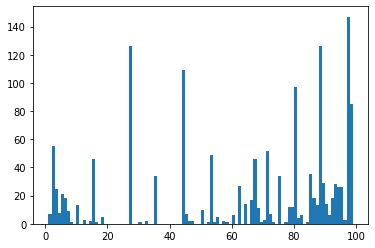

In [69]:
_=plt.hist(data['creatinine'].dropna(), bins=np.arange(1,100,1))

In [66]:
data[data['creatinine']> 1000]['creatinine'].value_counts()

1145.0    52
1193.0    29
1075.0    15
1076.0    14
1638.0    10
1081.0     7
1087.0     6
1315.0     4
1255.0     4
1363.0     1
1224.0     1
1019.0     1
3520.0     1
Name: creatinine, dtype: int64

### usg
Comparison of the density of urine to that of water
range 1.001 to 1.085
maybe the decimal ppint got forgotten in some places (e.g. in the 1000s)

(0.0, 300.0)

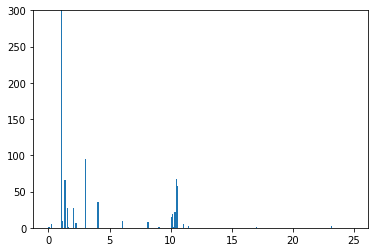

In [85]:
_=plt.hist(data['usg'].dropna(), bins=np.arange(0,25,0.1))
plt.ylim((0,300))

In [86]:
data[data['usg']<5]['usg'].value_counts()

1.050    2045
1.018     819
1.038     472
1.035     468
1.060     430
1.030     406
1.014     324
1.016     323
1.032     300
1.055     293
1.010     254
1.012     239
1.017     236
1.065     187
1.036     164
1.037     161
1.019     148
1.015     145
1.034     141
1.052     117
3.000      95
1.054      91
1.013      91
1.033      76
1.070      76
1.080      72
1.057      72
1.031      68
1.000      61
1.039      55
1.051      50
1.063      46
1.008      42
1.300      40
1.058      37
4.000      36
1.011      29
2.000      28
1.059      27
1.076      26
1.005      26
1.500      23
1.053      19
1.009      18
1.075      18
1.062      15
1.066      13
1.360      13
1.074      11
1.090      10
1.046       9
1.040       9
1.305       8
1.056       7
1.200       7
2.270       7
1.006       7
1.077       6
1.061       6
0.300       5
1.560       5
1.140       2
1.350       2
1.064       2
1.007       2
1.353       2
0.050       1
1.335       1
1.020       1
1.600       1
1.022       1
1.071 

In [87]:
data[data['usg']>1000]['usg'].value_counts()

1050.0    179
1035.0    123
1015.0     92
1038.0     66
1018.0     59
1014.0     46
1016.0     44
1013.0     32
1060.0     31
1037.0     28
1036.0     21
1070.0     17
1017.0     17
1058.0     16
1032.0     15
1030.0     14
1012.0      9
1039.0      7
1055.0      7
1009.0      5
1065.0      5
1010.0      5
1019.0      4
1034.0      3
1080.0      2
1033.0      1
Name: usg, dtype: int64

In [89]:
data[data['usg']<20]['usg'].value_counts()

1.050     2045
1.018      819
1.038      472
1.035      468
1.060      430
1.030      406
1.014      324
1.016      323
1.032      300
1.055      293
1.010      254
1.012      239
1.017      236
1.065      187
1.036      164
1.037      161
1.019      148
1.015      145
1.034      141
1.052      117
3.000       95
1.054       91
1.013       91
1.070       76
1.033       76
1.057       72
1.080       72
1.031       68
1.000       61
1.039       55
10.430      52
1.051       50
1.063       46
1.008       42
1.300       40
1.058       37
4.000       36
1.011       29
2.000       28
1.059       27
1.076       26
1.005       26
10.600      25
1.500       23
10.320      22
10.590      20
1.053       19
1.009       18
1.075       18
1.062       15
10.400      15
10.000      15
1.360       13
1.066       13
10.140      12
10.500      12
1.074       11
1.090       10
6.000       10
1.046        9
1.040        9
8.120        8
1.305        8
1.056        7
2.270        7
1.006        7
1.200     